<a href="https://colab.research.google.com/github/venetisgr/car_brand_identification/blob/main/pytorch_no_timm/pytorch_wand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Library Load

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Deep_Learning_GATECH/proj
print()
!ls

/content/drive/MyDrive/Deep_Learning_GATECH/proj

brands_only_dataset	      get_data.sh	  SAVED_MODELS	wandb
download_and_prep_data.ipynb  pytorch_wand.ipynb  VMMRdb


In [3]:
!pip install torchdata -q
!pip install wandb


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import transforms, datasets, models
import torchdata as td


/usr/local/lib/python3.7/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /usr/local/lib/python3.7/dist-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


In [5]:
import numpy as np
import pandas as pd

## 1. CFG - Config Dictionary

In [6]:
cfg = {
    "epochs" : 50,
    "batch_size" : 64,
    "learning_rate": 1e-3,

    "root_path": "brands_only_dataset/",
    "no_classes": 20,
    "no_images": 80355, 
}

## 2. Data Inspection

In [7]:
# from PIL import Image

# sample_img = Image.open("brands_only_dataset/chevrolet/00000_joUWFuOKRuK_600x450.jpg")
# sample_img

## 3. Data Transformation and Loaders

data augmentation:

https://datamahadev.com/performing-image-augmentation-using-pytorch/

https://www.kaggle.com/code/jaisilrose/data-augmentation-with-keras-tensorflow-pytorch



albumentations(if someone wants to try):https://www.kaggle.com/code/gabrielvinicius/simple-cnn-and-data-augmentation-with-pytorch

In [8]:
#data transformations



train_transform = transforms.Compose([
    transforms.Resize((150,150)), #faster computation
    ##augmentation
    transforms.GaussianBlur(kernel_size=(11,11), sigma=(0.05, 2)),
    transforms.RandomAffine(0, shear=10,scale=(0.8, 1.2)),
    #transforms.RandomAffine(degrees=30, translate=(0.2, 0.2), shear=0.2),
    transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomCrop([28, 28]),

    ##
    transforms.ToTensor(),
    #transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) #normalization set mean and std to 0.5 (of every channel)
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]) #needed for pretrained
])


val_transform = transforms.Compose([
    transforms.Resize((150,150)),#faster computation
    transforms.ToTensor(),
    #transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) #normalization set mean and std to 0.5 (of every channel)
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]) #needed for pretrained
])

test_transform = transforms.Compose([
    transforms.Resize((150,150)),#faster computation
    transforms.ToTensor(),
    #transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) #normalization set mean and std to 0.5 (of every channel)
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]) #needed for pretrained
])


In [9]:
#dataset creation and split


orig_set = torchvision.datasets.ImageFolder(cfg["root_path"])  # all images


indeces = np.arange(cfg["no_images"]) # indeces for total number of examples
np.random.shuffle(indeces) #shuffle indeces

train_count = int(0.7 * cfg["no_images"])
valid_count = int(0.15 * cfg["no_images"])
test_count = cfg["no_images"] - train_count - valid_count

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(
    orig_set, (train_count, valid_count, test_count)
)


In [10]:
len(orig_set),len(train_dataset),len(valid_dataset),len(test_dataset)

(80355, 56248, 12053, 12054)

In [11]:
type(train_dataset)

torch.utils.data.dataset.Subset

In [12]:
#apply transformation to each dataset

#doesnt work with subset
# train_dataset = train_dataset.map(train_transform)
# valid_dataset = valid_dataset.map(test_transform)
# test_dataset =  test_dataset.map(test_transform)

train_dataset.dataset.transform = train_transform
valid_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = test_transform


In [13]:
train_dataset[0][0].shape #we need to make it channel last

torch.Size([3, 150, 150])

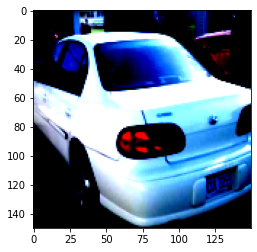

In [14]:
import matplotlib.pyplot as plt
#plt.imshow(train_dataset[0][0])
plt.imshow(train_dataset[0][0].transpose(0,1).transpose(1,2))
plt.show()

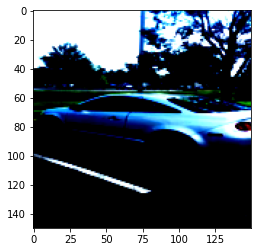

In [15]:
import matplotlib.pyplot as plt
#plt.imshow(train_dataset[0][0])
plt.imshow(valid_dataset[0][0].transpose(0,1).transpose(1,2))
plt.show()

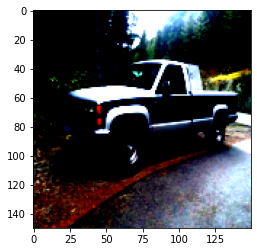

In [16]:
import matplotlib.pyplot as plt
#plt.imshow(train_dataset[0][0])
plt.imshow(test_dataset[0][0].transpose(0,1).transpose(1,2))
plt.show()

In [17]:
#dataloaders


train_dataset_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=cfg["batch_size"], shuffle=True, 
)
valid_dataset_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=cfg["batch_size"], shuffle=True,
)
test_dataset_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=cfg["batch_size"], shuffle=False,
)
dataloaders = {
    "train": train_dataset_loader,
    "val": valid_dataset_loader,
    "test": test_dataset_loader,
}

## 4. Architecture

In [18]:
model = models.resnet18(pretrained=True)
cfg["model"] = "resnet18"
print(model)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
set_parameter_requires_grad(model) #freeze model

In [20]:
model.fc = nn.Linear(512, cfg["no_classes"]) #replace final fc layer  #look at last layer of print above to see it

In [21]:
# Check which layer in the model that will compute the gradient
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[ 0.0400,  0.0174, -0.0254,  ...,  0.0218,  0.0091, -0.0145],
        [ 0.0272,  0.0256,  0.0112,  ..., -0.0347,  0.0182,  0.0340],
        [-0.0266, -0.0279,  0.0271,  ...,  0.0186, -0.0281,  0.0143],
        ...,
        [ 0.0013,  0.0187, -0.0385,  ..., -0.0170, -0.0200, -0.0258],
        [-0.0250,  0.0292,  0.0222,  ...,  0.0333,  0.0289,  0.0189],
        [ 0.0268, -0.0298,  0.0236,  ...,  0.0054, -0.0403, -0.0336]])
fc.bias tensor([ 0.0421,  0.0043,  0.0046, -0.0011,  0.0142, -0.0405,  0.0388,  0.0309,
        -0.0203,  0.0342,  0.0162,  0.0221,  0.0172,  0.0038, -0.0074,  0.0105,
        -0.0371,  0.0219,  0.0280,  0.0040])


## 5. Model Execution

In [22]:
import wandb
import os

os.environ['WANDB_NOTEBOOK_NAME'] = 'pytorch_wand'

In [23]:
wandb.login()

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find pytorch_wand.
wandb: Currently logged in as: venetispall. Use `wandb login --relogin` to force relogin


True

In [24]:
run = wandb.init(project="brand_identification_cnn_notimm", reinit="True", config=cfg)


In [25]:
model = model.to("cuda") #send model to gpu

criterion = nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.Adam(model.parameters(), lr=cfg["learning_rate"]) # algoritma backprop

In [26]:
#setup tqdm
# from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm

In [27]:
train_dataloader_len = int(len(train_dataset_loader))
valid_dataloader_len = int(len(valid_dataset_loader))
test_dataloader_len = int(len(test_dataset_loader))

train_dataloader_len,valid_dataloader_len ,test_dataloader_len

(879, 189, 189)

In [28]:
def validate(model,loader,length):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        total_sample = 0    
        total_correct = 0
        # for image, label in loader:
        #     image = image.to("cuda")
        #     label = label.to("cuda")
        tk1 = tqdm(loader, total=length)

        for bi, d in enumerate(tk1): 
            image = d[0].to('cuda') 
            label = d[1].to('cuda')

            out = model(image)
            loss = criterion(out, label)
            total_loss += loss.item()
            total_sample += len(label)
            total_correct += torch.sum(torch.max(out, 1)[1] == label).item()*1.0


    print(total_loss/total_sample, total_correct/total_sample)
            
    return  total_loss/total_sample, total_correct/total_sample

In [29]:
import copy
from collections import defaultdict

# from colorama import Fore, Back, Style
# c_ = Fore.CYAN
# sr_ = Style.RESET_ALL


In [ ]:
wandb.watch(model, criterion, log="all", log_freq=10) # WANDB WATCH

##keep best epoch
best_model_wts = copy.deepcopy(model.state_dict())
best_epoch_acc = 0 #val wise
history = defaultdict(list)
##
for i in range(cfg["epochs"]):
    model.train()
    
    total_loss = 0
    total_sample = 0
    total_correct = 0

    tk0 = tqdm(train_dataset_loader, total=train_dataloader_len)
    #for image, label in train_dataset_loader: 
        # image = image.to('cuda') 
        # label = label.to('cuda') 
    for bi, d in enumerate(tk0): 
        image = d[0].to('cuda') 
        label = d[1].to('cuda') 
        
        out = model(image) # STEP 1: forward propagation
        loss = criterion(out, label) # STEP 2: calculate loss
        optimizer.zero_grad() # STEP 3: zero out the gradient. see: https://stackoverflow.com/q/48001598/2147347
        loss.backward() # STEP 4: backpropagation
        optimizer.step() # STEP 5: update the model
        
        total_loss += loss # sum of losses for this epoch
        total_sample += len(label) # number seen images in this epoch
        total_correct += torch.sum(torch.max(out,1)[1]==label)*1.0 # sum of the correct prediction
        
    loss = total_loss/total_sample # averaging loss
    acc = total_correct/total_sample # averaging accuracy
    
    val_loss, val_acc = validate(model,valid_dataset_loader,valid_dataloader_len) # validate using data "test" at the end of an epoch

    ##keep the best model 
    # deep copy the model
    if val_acc >= best_epoch_acc:
        print(f"Validation Acc Improved ({best_epoch_acc} ---> {val_acc})")
        best_epoch_acc = val_acc
        run.summary["Best Val Accuracy"] = best_epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        PATH = "SAVED_MODELS/" +cfg["model"]+"_"+str(cfg["learning_rate"])+ "_ACC{:.4f}_epoch{:.0f}.pt".format(best_epoch_acc, i)
        torch.save(model.state_dict(), PATH)
        # Save a model file from the current directory
        print(f"Model Saved")


    ##
    
    wandb.log({"loss":loss, "acc":acc, "val_loss": val_loss, "val_acc":val_acc}, step=i) # WANDB LOG
    
    print(f"epoch {i} loss:{total_loss/total_sample}  acc:{total_correct/total_sample}") # our personal log
    print()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


  0%|          | 0/879 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/189 [00:00<?, ?it/s]

0.02135965590317556 0.5284991288475898
Validation Acc Improved (0 ---> 0.5284991288475898)
Model Saved
epoch 0 loss:0.02290603332221508  acc:0.5019911527633667



  0%|          | 0/879 [00:00<?, ?it/s]

  0%|          | 0/189 [00:00<?, ?it/s]

0.02106260752901441 0.5351364805442629
Validation Acc Improved (0 ---> 0.5351364805442629)
Model Saved
epoch 1 loss:0.02123299241065979  acc:0.5309877395629883



  0%|          | 0/879 [00:00<?, ?it/s]

  0%|          | 0/189 [00:00<?, ?it/s]

0.020812443259503547 0.5340579108935535
Validation Acc Improved (0 ---> 0.5340579108935535)
Model Saved
epoch 2 loss:0.020805541425943375  acc:0.5394502878189087



  0%|          | 0/879 [00:00<?, ?it/s]

  0%|          | 0/189 [00:00<?, ?it/s]

0.0205940935885294 0.5419397660333527
Validation Acc Improved (0 ---> 0.5419397660333527)
Model Saved
epoch 3 loss:0.020540885627269745  acc:0.5450860261917114



  0%|          | 0/879 [00:00<?, ?it/s]

  0%|          | 0/189 [00:00<?, ?it/s]

0.020523114342081452 0.5455903094665229
Validation Acc Improved (0 ---> 0.5455903094665229)
Model Saved
epoch 4 loss:0.02043885365128517  acc:0.5460460782051086



  0%|          | 0/879 [00:00<?, ?it/s]

  0%|          | 0/189 [00:00<?, ?it/s]

0.020498094158747045 0.5443458060233967
Validation Acc Improved (0 ---> 0.5443458060233967)
Model Saved
epoch 5 loss:0.020426683127880096  acc:0.5450326800346375



  0%|          | 0/879 [00:00<?, ?it/s]

  0%|          | 0/189 [00:00<?, ?it/s]

0.02050098114406124 0.5465859122210238
Validation Acc Improved (0 ---> 0.5465859122210238)
Model Saved
epoch 6 loss:0.02030295878648758  acc:0.5481616854667664



  0%|          | 0/879 [00:00<?, ?it/s]

  0%|          | 0/189 [00:00<?, ?it/s]

0.021268597779052045 0.5176304654442877
Validation Acc Improved (0 ---> 0.5176304654442877)
Model Saved
epoch 7 loss:0.020255383104085922  acc:0.5479661226272583



  0%|          | 0/879 [00:00<?, ?it/s]

  0%|          | 0/189 [00:00<?, ?it/s]

0.02053220970526005 0.5505683232390276
Validation Acc Improved (0 ---> 0.5505683232390276)
Model Saved
epoch 8 loss:0.020256999880075455  acc:0.5474327802658081



  0%|          | 0/879 [00:00<?, ?it/s]

In [ ]:
los, acc = validate(model,test_dataset_loader,test_dataloader_len)

#log test accuracy and loss
wandb.log({"test_loss": los, 
           "test_acc": acc ,
          })

In [ ]:
# # Save the model, save it to wandb server
# torch.save(model.state_dict(), "model.pt")
# wandb.save('model.pt')

In [ ]:
run.finish()